# Criando um dataset inicial

Nesse notebook será criado um dataset e salvaremos os dados de h5py.
A ideia aqui é para cada janela valida de sinal de EEG (janelas de 5 minutos), salvarmos o sinal (.h5) com seu respectivo metadado (.csv). Assim, conseguimos depois parear as duas informações para começar a fazer o treinamento dos modelos.

Com o dataset criado, dá pra começar a brincar com os modelos.

In [1]:
#!pip install h5py

In [2]:
import os.path
import pandas as pd
import h5py
import numpy as np
from tqdm.auto import tqdm
import wfdb

C:\Users\estel\AppData\Local\Temp\ipykernel_1104\1128037816.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\estel\anaconda3\envs\estudos\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def find_data_folders(root_folder):
    """
    Find and return a sorted list of subfolders inside the given root folder.

    Parameters
    ----------
    root_folder : str
        The root folder to search for subfolders.

    Returns
    -------
    List of str
        A sorted list of subfolders inside the root folder.
    """
    data_folders = list()
    for x in os.listdir(root_folder):
        data_folder = os.path.join(root_folder, x)
        if os.path.isdir(data_folder):
            data_folders.append(x)
    return sorted(data_folders)

In [4]:
def get_reference(data_folder: str,
                  fill_nan: bool | float = 0,
                  verbosity: int = 0) -> pd.DataFrame:
    """
      Generate a reference table containing patient metadata and EEG record information from data files located in the specified folder.

      Parameters
      ----------
      data_folder : str
          The path to the folder containing the patient data files.
      fill_nan : bool | float, optional
          If a float value, fill in missing values with the value specified. If `False`, do not fill in missing values.
          Default is `0`.
      verbosity : int, optional
          Controls the verbosity of the function. If greater than 0, print out progress messages.
          Default is `0`.

      Returns
      -------
      pd.DataFrame
          A reference table containing patient metadata and ECG record information from data files located in the specified folder.
          The table contains the following columns:
          - Hour: integer hour of the EEG recording
          - Time: the time of the EEG recording, in decimal hours
          - Quality:
          - Record: the filename of the EEG recording
          - path: the path of the EEG recording
          - Patient: the ID of the patient in the format "ICARE_xxxx"
          - Age: the patient's age
          - Sex: the patient's sex, encoded as -1.0 for male, 1.0 for female
          - ROSC:
          - OHCA: whether the patient suffered an out-of-hospital cardiac arrest, encoded as -1.0 for False, 1.0 for True
          - VFib: whether the patient was diagnosed with ventricular fibrillation, encoded as -1.0 for False, 1.0 for True
          - Outcome: the patient's outcome, encoded as 0.0 for Good, 1.0 for Poor
          - CPC:
          - ID: the ID of the patient as an integer
      """
    dfs = []
    if verbosity > 0:
        print("Generating reference table...")

    for patient_folder in find_data_folders(data_folder) if verbosity <= 1 else tqdm(find_data_folders(data_folder)):
        # Stem for the metadata files (.txt and .tsv)
        metadata_file_stem = os.path.normpath(os.path.join(data_folder, patient_folder, patient_folder))

        # Extract the patient metadata
        patient_metadata = pd.read_csv(
            f"{metadata_file_stem}.txt",
            delimiter=": ",
            header=None,
            index_col=0,
            engine='python'
        ).T.reset_index(drop=True)
        
        patient_metadata[['Age', 'ROSC', 'TTM']] = patient_metadata[['Age', 'ROSC', 'TTM']].fillna(value=fill_nan)
        patient_metadata["ID"] = patient_metadata['Patient']
        patient_metadata['CPC'] = patient_metadata['CPC'].astype(int)
        patient_metadata['CPC'] = patient_metadata['CPC'] - 1

        # Extract
        records_metadata = pd.read_csv(f"{metadata_file_stem}.tsv", delimiter='\t', engine='python')
        records_metadata.dropna(inplace=True)
        records_metadata['Time'] = records_metadata.Time
        records_metadata['path'] = records_metadata.Record.apply(
            lambda rec: os.path.normpath(os.path.join(data_folder, patient_folder, rec))
        )
        records_metadata['Patient'] = patient_metadata.Patient[0]
        records_metadata['Time'] = records_metadata['Time']
        records_metadata['Record'] = records_metadata['Record'].astype('string')
        records_metadata['path'] = records_metadata['path'].astype('string')
        records_metadata['Patient'] = records_metadata['Patient'].astype('string')

        dfs.append(
            pd.merge(
                patient_metadata,
                records_metadata,
                on='Patient',
            )
        )
    if verbosity > 0:
        print("Reference table created!")

    return pd.concat(dfs).reset_index(drop=True)

In [5]:
DIR = r'C:/Users/estel/Documents/Python_Codes/datasets/i-care-international-cardiac-arrest-research-consortium-database-1.0/training/'
DATA_FOLDER = DIR

OUTPUT_DATASET_PATH = "training.h5"
OUTPUT_REFERENCE_PATH = "training.csv"

In [6]:
if os.path.isfile(OUTPUT_REFERENCE_PATH):
    print("Reading dataset reference table... ", flush=True, end="")
    reference_table_ = pd.read_csv(OUTPUT_REFERENCE_PATH)
else:
    print("Generating dataset reference table... ", flush=True, end="")
    reference_table_ = get_reference(DATA_FOLDER)
    reference_table_.to_csv(OUTPUT_REFERENCE_PATH, index=False)
print("Done!", flush=True)

Generating dataset reference table... 

C:\Users\estel\AppData\Local\Temp\ipykernel_1104\2409541010.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  patient_metadata[['Age', 'ROSC', 'TTM']] = patient_metadata[['Age', 'ROSC', 'TTM']].fillna(value=fill_nan)
C:\Users\estel\AppData\Local\Temp\ipykernel_1104\2409541010.py:55: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  patient_metadata[['Age', 'ROSC', 'TTM']] = patient_metadata[['Age', 'ROSC', 'TTM']].fillna(value=fill_nan)
C:\Users\estel\AppData\Local\Temp\ipykernel_1104\2409541010.py:55: FutureWarning: Downcasting object dtype arrays on .fi

Done!


In [7]:
reference_table_

,Patient,Age,Sex,ROSC,OHCA,VFib,TTM,Outcome,CPC,ID,Hour,Time,Quality,Record,path
0,ICARE_0284,53,Male,0,True,True,33,Good,0,ICARE_0284,5,04:25,1.000,ICARE_0284_05,C:\Users\estel\Documents\Python_Codes\datasets...
1,ICARE_0284,53,Male,0,True,True,33,Good,0,ICARE_0284,6,05:55,1.000,ICARE_0284_06,C:\Users\estel\Documents\Python_Codes\datasets...
2,ICARE_0284,53,Male,0,True,True,33,Good,0,ICARE_0284,7,06:50,1.000,ICARE_0284_07,C:\Users\estel\Documents\Python_Codes\datasets...
3,ICARE_0284,53,Male,0,True,True,33,Good,0,ICARE_0284,8,07:55,1.000,ICARE_0284_08,C:\Users\estel\Documents\Python_Codes\datasets...
4,ICARE_0284,53,Male,0,True,True,33,Good,0,ICARE_0284,9,08:55,0.983,ICARE_0284_09,C:\Users\estel\Documents\Python_Codes\datasets...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13963,ICARE_0738,54,Female,5,True,True,33,Good,0,ICARE_0738,6,05:55,1.000,ICARE_0738_06,C:\Users\estel\Documents\Python_Codes\datasets...
13964,ICARE_0738,54,Female,5,True,True,33,Good,0,ICARE_0738,7,06:55,1.000,ICARE_0738_07,C:\Users\estel\Documents\Python_Codes\datasets...
13965,ICARE_0738,54,Female,5,True,True,33,Good,0,ICARE_0738,8,07:55,1.000,ICARE_0738_08,C:\Users\estel\Documents\Python_Codes\datasets...
13966,ICARE_0738,54,Female,5,True,True,33,Good,0,ICARE_0738,9,08:55,1.000,ICARE_0738_09,C:\Users\estel\Documents\Python_Codes\datasets...


In [8]:
reference_table_['path'][0]

'C:\\Users\\estel\\Documents\\Python_Codes\\datasets\\i-care-international-cardiac-arrest-research-consortium-database-1.0\\training\\ICARE_0284\\ICARE_0284_05'

In [9]:
# Channels order
CHANNELS = ['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2', 'Fp1-F3',
            'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'Fz-Cz', 'Cz-Pz']

N_SIGNALS = len(reference_table_)
print(N_SIGNALS)
SIGNAL_LEN = 5 * 60 * 100
N_CHANNELS = 18

13968


In [10]:
print("Generating dataset file...", flush=True)
with h5py.File(OUTPUT_DATASET_PATH, 'w') as f:
    dset = f.create_dataset("signals", (N_SIGNALS, SIGNAL_LEN, N_CHANNELS), dtype='int16')
    for idx, row in tqdm(enumerate(reference_table_.iloc), total=N_SIGNALS, mininterval=5):
        eeg = wfdb.rdsamp(row.path, channel_names=CHANNELS)[0]
        header = wfdb.rdheader(row.path)
        eeg = (eeg * header.adc_gain).astype(np.int16)
        dset[idx] = eeg
print("Dataset created successfully!", flush=True)

Generating dataset file...


100%|██████████| 13968/13968 [15:43<00:00, 14.81it/s]


Dataset created successfully!


In [11]:
# Um sinal de EEG
eeg.shape

(30000, 18)

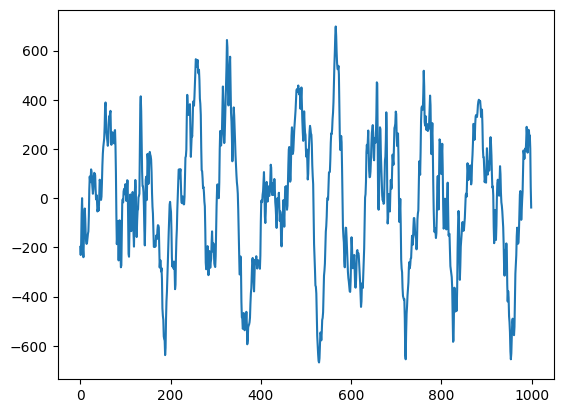

In [15]:
import matplotlib.pyplot as plt

# Plotando o começo de um sinal de eeg (1 eletrodo)
plt.plot(eeg[:1000,0])